In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import pandas as pd
import requests
import glob

### Data Loading

In [2]:
trip_files = glob.glob("./202409-citibike-tripdata/*")

In [3]:
df = pd.concat([ 
    pd.read_csv(
        tf,
        parse_dates=["started_at", "ended_at"],
        dtype={
            "start_station_name": str,
            "end_station_name": str,
            "start_station_id": str,
            "end_station_id": str
        }
    ) for tf in trip_files
])

In [4]:
df.shape

(4997898, 13)

In [5]:
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD5299CB404DEC67,classic_bike,2024-09-06 18:53:56.193,2024-09-06 18:57:08.782,Forest Ave & Summerfield St,4798.02,St Felix Ave & 61 St,4719.04,40.699220,-73.897950,40.697150,-73.893600,member
1,743B1F43BCC71F11,electric_bike,2024-09-02 21:09:09.862,2024-09-02 21:13:16.881,E 7 St & Ave B,5584.05,Rivington St & Ridge St,5406.02,40.725129,-73.981317,40.718502,-73.983299,member
2,1642CEBE805FA026,electric_bike,2024-09-17 07:29:14.311,2024-09-17 08:03:10.812,7 Ave & 20 St,3588.01,Central Ave & Woodbine St,4632.10,40.659053,-73.988540,40.692960,-73.916050,member
3,B4D4FA8F4D1B7A79,electric_bike,2024-09-13 12:39:51.392,2024-09-13 12:59:46.772,E 53 St & 3 Ave,6617.02,Rivington St & Ridge St,5406.02,40.757632,-73.969306,40.718502,-73.983299,member
4,B6A18EDFBB29C904,classic_bike,2024-09-23 08:52:08.749,2024-09-23 08:55:59.812,Cadman Plaza E & Red Cross Pl,4821.06,Main St & Plymouth St,4936.21,40.699918,-73.989718,40.703782,-73.990734,member


### Add Additional Information

We are going to cluster stations on the following attributes:

- percentage of weekend start / ends
- percentage of commuting hour start / ends (defining that as 7-9 am and 5-7 pm)
- percentage of member vs. casual start / ends
- percentage of classic vs. electric start / ends
- average ride time for departing / arriving start / ends
- total number of start / ends

In order to make generating some of these data points easier we will add some metadata columns.

In [7]:
# weekday of datetime is 0 - Monday through 6 - Sunday
df['is_weekend_start'] = df['started_at'].apply(lambda x: x.weekday() in [5,6])
df['is_weekend_end'] = df['ended_at'].apply(lambda x: x.weekday() in [5,6])

In [8]:
df['is_weekend_start'].value_counts(normalize=True)

is_weekend_start
False    0.739934
True     0.260066
Name: proportion, dtype: float64

In [9]:
# hour uses a 24-hour clock so this is any time starting in the 7 or 8 am hour or 5 or 6 pm hours
df['is_commute_start'] = df.apply(lambda x:  (not x['is_weekend_start']) and (x['started_at'].hour in [7,8,17,18]), axis=1)

In [10]:
df['is_commute_end'] = df.apply(lambda x: (not x['is_weekend_end']) and (x['ended_at'].hour in [7,8,17,18]), axis=1)

In [11]:
# this is to just make sure we're doing this correctly
df.sample(10)[['started_at', 'is_weekend_start', 'is_commute_start', 'ended_at', 'is_weekend_end', 'is_commute_end']]

,started_at,is_weekend_start,is_commute_start,ended_at,is_weekend_end,is_commute_end
838716,2024-09-02 16:42:53.341,False,False,2024-09-02 16:48:51.075,False,False
302855,2024-09-09 13:17:26.016,False,False,2024-09-09 13:33:53.448,False,False
721719,2024-09-19 17:22:02.451,False,True,2024-09-19 17:29:50.524,False,True
190631,2024-09-27 10:45:49.330,False,False,2024-09-27 10:57:09.810,False,False
840546,2024-09-23 19:00:58.719,False,False,2024-09-23 19:06:01.658,False,False
441398,2024-09-25 13:46:54.425,False,False,2024-09-25 13:53:11.988,False,False
746984,2024-09-21 23:41:41.420,True,False,2024-09-21 23:48:35.640,True,False
832706,2024-09-08 22:08:28.228,True,False,2024-09-08 22:24:15.353,True,False
711023,2024-09-28 08:26:09.356,True,False,2024-09-28 08:39:36.388,True,False
343238,2024-09-15 13:33:35.853,True,False,2024-09-15 13:36:35.744,True,False


In [12]:
df['total_ride_time'] = df.apply(lambda x: x['ended_at'] - x['started_at'], axis=1)

In [13]:
df.head()['total_ride_time']

0   0 days 00:03:12.589000
1   0 days 00:04:07.019000
2   0 days 00:33:56.501000
3   0 days 00:19:55.380000
4   0 days 00:03:51.063000
Name: total_ride_time, dtype: timedelta64[ns]

In [14]:
df.total_ride_time.dtype

dtype('<m8[ns]')

### Reframe Data To Be About Stations

In [15]:
# only trips that start and end
df_trips_start_end = df.loc[lambda x: ~x['started_at'].isnull() & ~x['ended_at'].isnull()].copy()

In [16]:
start_groupby = (
    df_trips_start_end
    .groupby('start_station_id')
    .pipe(lambda grp:
        pd.DataFrame({
            'total_rides': grp.size(),
            'weekend_rides': grp['is_weekend_start'].sum(),
            'commute_rides': grp['is_commute_start'].sum(),
            'average_ride_time': grp['total_ride_time'].mean(),
            'electric_rides': grp['rideable_type'].apply(lambda x: (x == 'electric_bike').sum()),
            'member_rides': grp['member_casual'].apply(lambda x: (x == 'member').sum())
        })
    )
    .assign(pct_weekend=lambda df: df.apply(lambda x: x['weekend_rides'] / x['total_rides'], axis=1))
    .assign(pct_commute=lambda df: df.apply(lambda x: x['commute_rides'] / x['total_rides'], axis=1))
    .assign(pct_electric=lambda df: df.apply(lambda x: x['electric_rides'] / x['total_rides'], axis=1))
    .assign(pct_member=lambda df: df.apply(lambda x: x['member_rides'] / x['total_rides'], axis=1))
)

In [17]:
start_groupby.head()

,total_rides,weekend_rides,commute_rides,average_ride_time,electric_rides,member_rides,pct_weekend,pct_commute,pct_electric,pct_member
start_station_id,,,,,,,,,,
2733.03,282,85,78,0 days 00:20:35.118336879,197,217,0.301418,0.276596,0.698582,0.769504
2782.02,322,101,56,0 days 00:19:30.524068322,234,215,0.313665,0.173913,0.726708,0.667702
2821.06,339,97,45,0 days 00:18:30.561834808,232,249,0.286136,0.132743,0.684366,0.734513
2832.03,435,117,112,0 days 00:20:36.370733333,305,324,0.268966,0.257471,0.701149,0.744828
2861.02,292,74,54,0 days 00:11:40.526568493,188,238,0.253425,0.184932,0.643836,0.815068


In [18]:
end_groupby = (
    df_trips_start_end
    .groupby('end_station_id')
    .pipe(lambda grp:
        pd.DataFrame({
            'total_rides': grp.size(),
            'weekend_rides': grp['is_weekend_end'].sum(),
            'commute_rides': grp['is_commute_end'].sum(),
            'average_ride_time': grp['total_ride_time'].mean(),
            'electric_rides': grp['rideable_type'].apply(lambda x: (x == 'electric_bike').sum()),
            'member_rides': grp['member_casual'].apply(lambda x: (x == 'member').sum())
        })
    )
    .assign(pct_weekend=lambda df: df.apply(lambda x: x['weekend_rides'] / x['total_rides'], axis=1))
    .assign(pct_commute=lambda df: df.apply(lambda x: x['commute_rides'] / x['total_rides'], axis=1))
    .assign(pct_electric=lambda df: df.apply(lambda x: x['electric_rides'] / x['total_rides'], axis=1))
    .assign(pct_member=lambda df: df.apply(lambda x: x['member_rides'] / x['total_rides'], axis=1))
)

In [19]:
end_groupby.head()

,total_rides,weekend_rides,commute_rides,average_ride_time,electric_rides,member_rides,pct_weekend,pct_commute,pct_electric,pct_member
end_station_id,,,,,,,,,,
2733.03,283,88,65,0 days 00:26:53.874929328,201,212,0.310954,0.229682,0.710247,0.749117
2782.02,325,98,71,0 days 00:20:53.075258461,237,232,0.301538,0.218462,0.729231,0.713846
2821.06,355,111,70,0 days 00:18:04.902354929,247,275,0.312676,0.197183,0.695775,0.774648
2832.03,439,118,124,0 days 00:22:15.244694760,308,301,0.268793,0.282460,0.701595,0.685649
2861.02,317,84,48,0 days 00:16:39.978899053,198,256,0.264984,0.151420,0.624606,0.807571


In [20]:
# Merge Start and End for a Complete Dataframe and only use stations with starts and end
merged_station_trip_data = start_groupby.join(end_groupby, how='outer', lsuffix='_start', rsuffix='_end').dropna()

In [21]:
# That's still almost 2,200 docks and they look like this
merged_station_trip_data.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,total_rides_end,weekend_rides_end,commute_rides_end,average_ride_time_end,electric_rides_end,member_rides_end,pct_weekend_end,pct_commute_end,pct_electric_end,pct_member_end
2733.03,282.0,85.0,78.0,0 days 00:20:35.118336879,197.0,217.0,0.301418,0.276596,0.698582,0.769504,283.0,88.0,65.0,0 days 00:26:53.874929328,201.0,212.0,0.310954,0.229682,0.710247,0.749117
2782.02,322.0,101.0,56.0,0 days 00:19:30.524068322,234.0,215.0,0.313665,0.173913,0.726708,0.667702,325.0,98.0,71.0,0 days 00:20:53.075258461,237.0,232.0,0.301538,0.218462,0.729231,0.713846
2821.06,339.0,97.0,45.0,0 days 00:18:30.561834808,232.0,249.0,0.286136,0.132743,0.684366,0.734513,355.0,111.0,70.0,0 days 00:18:04.902354929,247.0,275.0,0.312676,0.197183,0.695775,0.774648
2832.03,435.0,117.0,112.0,0 days 00:20:36.370733333,305.0,324.0,0.268966,0.257471,0.701149,0.744828,439.0,118.0,124.0,0 days 00:22:15.244694760,308.0,301.0,0.268793,0.282460,0.701595,0.685649
2861.02,292.0,74.0,54.0,0 days 00:11:40.526568493,188.0,238.0,0.253425,0.184932,0.643836,0.815068,317.0,84.0,48.0,0 days 00:16:39.978899053,198.0,256.0,0.264984,0.151420,0.624606,0.807571


### Station Metadata

We also want to do some mapping, so we'll need the latitude and longitude. We'll have to use the real-time data to get it!

In [22]:
import requests

In [23]:
r_station_information = requests.get("https://gbfs.lyft.com/gbfs/2.3/bkn/es/station_information.json")
station_metadata = pd.DataFrame.from_dict(r_station_information.json().get('data').get('stations'))

In [24]:
station_metadata.head()

,station_id,capacity,short_name,lat,name,region_id,lon,rental_uris
0,0bd9bd58-42e6-4680-9d19-83943372221f,22,2912.08,40.638196,6 Ave & 60 St,71,-74.013821,{'android': 'https://bkn.lft.to/lastmile_qr_sc...
1,816e50eb-dc4b-47dc-b773-154e2020cb0d,19,3084.05,40.642703,52 St & 6 Ave,71,-74.009441,{'android': 'https://bkn.lft.to/lastmile_qr_sc...
2,09dfc0e3-a448-477c-bb3c-9467dc51ef8d,75,5989.02,40.738046,W 15 St & 6 Ave,71,-73.996430,{'android': 'https://bkn.lft.to/lastmile_qr_sc...
3,66dd4ccc-0aca-11e7-82f6-3863bb44ef7c,51,7141.07,40.775794,Central Park West & W 72 St,71,-73.976206,{'android': 'https://bkn.lft.to/lastmile_qr_sc...
4,06439006-11b6-44f0-8545-c9d39035f32a,78,5216.06,40.712220,Vesey St & Church St,71,-74.010472,{'android': 'https://bkn.lft.to/lastmile_qr_sc...


In [25]:
station_lat_lon = station_metadata[['short_name', 'lat', 'lon']].set_index('short_name')

### End Result

In [26]:
station_trip_meta = merged_station_trip_data.join(station_lat_lon, how='left').dropna()

In [27]:
# turning it into a GeoDataFrame for plotting purposes
g_stations = gpd.GeoDataFrame(
    station_trip_meta,
    geometry=gpd.points_from_xy(station_trip_meta.lon, station_trip_meta.lat),
    crs="EPSG:4326")

### Where Are The Stations?

Before we do any clustering let's see where the stations are.

In [28]:
# Read GeoJSON file
gdf = gpd.read_file("new-york-city-boroughs.geojson")

In [29]:
g_stations = g_stations.to_crs(gdf.crs)

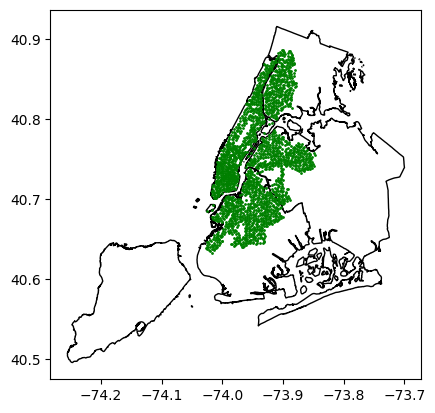

In [30]:
# Plot the data
base = gdf.plot(color='white', edgecolor='black')
g_stations.plot(ax=base, marker='o', color='green', markersize=1)
plt.show()

### Normalize The Data

Percentages are on a scale of 0-1 because K-Means clustering is about distance we want everything else to be on a similar scale. In order to do that we're going to "normalize" a few columns by dividing by the maximum amount in that column.

In [31]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,average_ride_time_end,electric_rides_end,member_rides_end,pct_weekend_end,pct_commute_end,pct_electric_end,pct_member_end,lat,lon,geometry
2733.03,282.0,85.0,78.0,0 days 00:20:35.118336879,197.0,217.0,0.301418,0.276596,0.698582,0.769504,...,0 days 00:26:53.874929328,201.0,212.0,0.310954,0.229682,0.710247,0.749117,40.633385,-74.016562,POINT (-74.01656 40.63338)
2782.02,322.0,101.0,56.0,0 days 00:19:30.524068322,234.0,215.0,0.313665,0.173913,0.726708,0.667702,...,0 days 00:20:53.075258461,237.0,232.0,0.301538,0.218462,0.729231,0.713846,40.635679,-74.020005,POINT (-74.02 40.63568)
2821.06,339.0,97.0,45.0,0 days 00:18:30.561834808,232.0,249.0,0.286136,0.132743,0.684366,0.734513,...,0 days 00:18:04.902354929,247.0,275.0,0.312676,0.197183,0.695775,0.774648,40.635928,-74.013256,POINT (-74.01326 40.63593)
2832.03,435.0,117.0,112.0,0 days 00:20:36.370733333,305.0,324.0,0.268966,0.257471,0.701149,0.744828,...,0 days 00:22:15.244694760,308.0,301.0,0.268793,0.282460,0.701595,0.685649,40.637033,-74.022141,POINT (-74.02214 40.63703)
2861.02,292.0,74.0,54.0,0 days 00:11:40.526568493,188.0,238.0,0.253425,0.184932,0.643836,0.815068,...,0 days 00:16:39.978899053,198.0,256.0,0.264984,0.151420,0.624606,0.807571,40.638566,-74.010147,POINT (-74.01015 40.63857)


In [32]:
columns_to_norm = [
    'total_rides_start',
    'average_ride_time_start',
    'total_rides_end',
    'average_ride_time_end'
]

In [33]:
for c in columns_to_norm:
    g_stations[c + '_norm'] = g_stations[c].apply(lambda x: x / g_stations[c].max())

In [34]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,pct_commute_end,pct_electric_end,pct_member_end,lat,lon,geometry,total_rides_start_norm,average_ride_time_start_norm,total_rides_end_norm,average_ride_time_end_norm
2733.03,282.0,85.0,78.0,0 days 00:20:35.118336879,197.0,217.0,0.301418,0.276596,0.698582,0.769504,...,0.229682,0.710247,0.749117,40.633385,-74.016562,POINT (-74.01656 40.63338),0.016165,0.281145,0.016213,0.316868
2782.02,322.0,101.0,56.0,0 days 00:19:30.524068322,234.0,215.0,0.313665,0.173913,0.726708,0.667702,...,0.218462,0.729231,0.713846,40.635679,-74.020005,POINT (-74.02 40.63568),0.018458,0.266442,0.018619,0.246028
2821.06,339.0,97.0,45.0,0 days 00:18:30.561834808,232.0,249.0,0.286136,0.132743,0.684366,0.734513,...,0.197183,0.695775,0.774648,40.635928,-74.013256,POINT (-74.01326 40.63593),0.019433,0.252793,0.020338,0.213009
2832.03,435.0,117.0,112.0,0 days 00:20:36.370733333,305.0,324.0,0.268966,0.257471,0.701149,0.744828,...,0.282460,0.701595,0.685649,40.637033,-74.022141,POINT (-74.02214 40.63703),0.024936,0.281430,0.025150,0.262161
2861.02,292.0,74.0,54.0,0 days 00:11:40.526568493,188.0,238.0,0.253425,0.184932,0.643836,0.815068,...,0.151420,0.624606,0.807571,40.638566,-74.010147,POINT (-74.01015 40.63857),0.016738,0.159458,0.018161,0.196335


### Cluster The Data

1. How many clusters should there be?
2. Actually create the clusters

One way to determine how many clusters there should be is the Elbow Method. Basically you look for the point at which the "inertia" of the clusters starts to go down linearly.

In [35]:
features = [
    'total_rides_start_norm',
    'pct_weekend_start',
    'pct_commute_start',
    'pct_electric_start',
    'pct_member_start',
    'average_ride_time_start_norm',
    'total_rides_end_norm',
    'pct_weekend_end',
    'pct_commute_end',
    'pct_electric_end',
    'pct_member_end'
]

In [36]:
inertias = []

In [37]:
for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(g_stations[features])
    inertias.append(kmeans.inertia_)

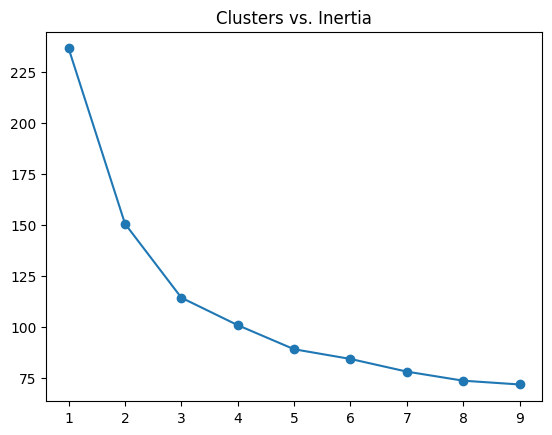

In [38]:
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia')
plt.show()

From the graph above it looks like either 3 or 4 would probably be a good number to use for our clusters. Let's try separating them into 4 clusters!

In [39]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(g_stations[features])

KMeans(n_clusters=4)

In [40]:
g_stations['kmeans_label'] = kmeans.labels_

In [41]:
g_stations.head()

,total_rides_start,weekend_rides_start,commute_rides_start,average_ride_time_start,electric_rides_start,member_rides_start,pct_weekend_start,pct_commute_start,pct_electric_start,pct_member_start,...,pct_electric_end,pct_member_end,lat,lon,geometry,total_rides_start_norm,average_ride_time_start_norm,total_rides_end_norm,average_ride_time_end_norm,kmeans_label
2733.03,282.0,85.0,78.0,0 days 00:20:35.118336879,197.0,217.0,0.301418,0.276596,0.698582,0.769504,...,0.710247,0.749117,40.633385,-74.016562,POINT (-74.01656 40.63338),0.016165,0.281145,0.016213,0.316868,1
2782.02,322.0,101.0,56.0,0 days 00:19:30.524068322,234.0,215.0,0.313665,0.173913,0.726708,0.667702,...,0.729231,0.713846,40.635679,-74.020005,POINT (-74.02 40.63568),0.018458,0.266442,0.018619,0.246028,1
2821.06,339.0,97.0,45.0,0 days 00:18:30.561834808,232.0,249.0,0.286136,0.132743,0.684366,0.734513,...,0.695775,0.774648,40.635928,-74.013256,POINT (-74.01326 40.63593),0.019433,0.252793,0.020338,0.213009,1
2832.03,435.0,117.0,112.0,0 days 00:20:36.370733333,305.0,324.0,0.268966,0.257471,0.701149,0.744828,...,0.701595,0.685649,40.637033,-74.022141,POINT (-74.02214 40.63703),0.024936,0.281430,0.025150,0.262161,1
2861.02,292.0,74.0,54.0,0 days 00:11:40.526568493,188.0,238.0,0.253425,0.184932,0.643836,0.815068,...,0.624606,0.807571,40.638566,-74.010147,POINT (-74.01015 40.63857),0.016738,0.159458,0.018161,0.196335,1


In [42]:
# There is a pretty even split here!
g_stations['kmeans_label'].value_counts()

kmeans_label
1    902
0    631
2    434
3    158
Name: count, dtype: int64

In [43]:
# more space
mpl.rcParams['figure.figsize'] = [12, 12]

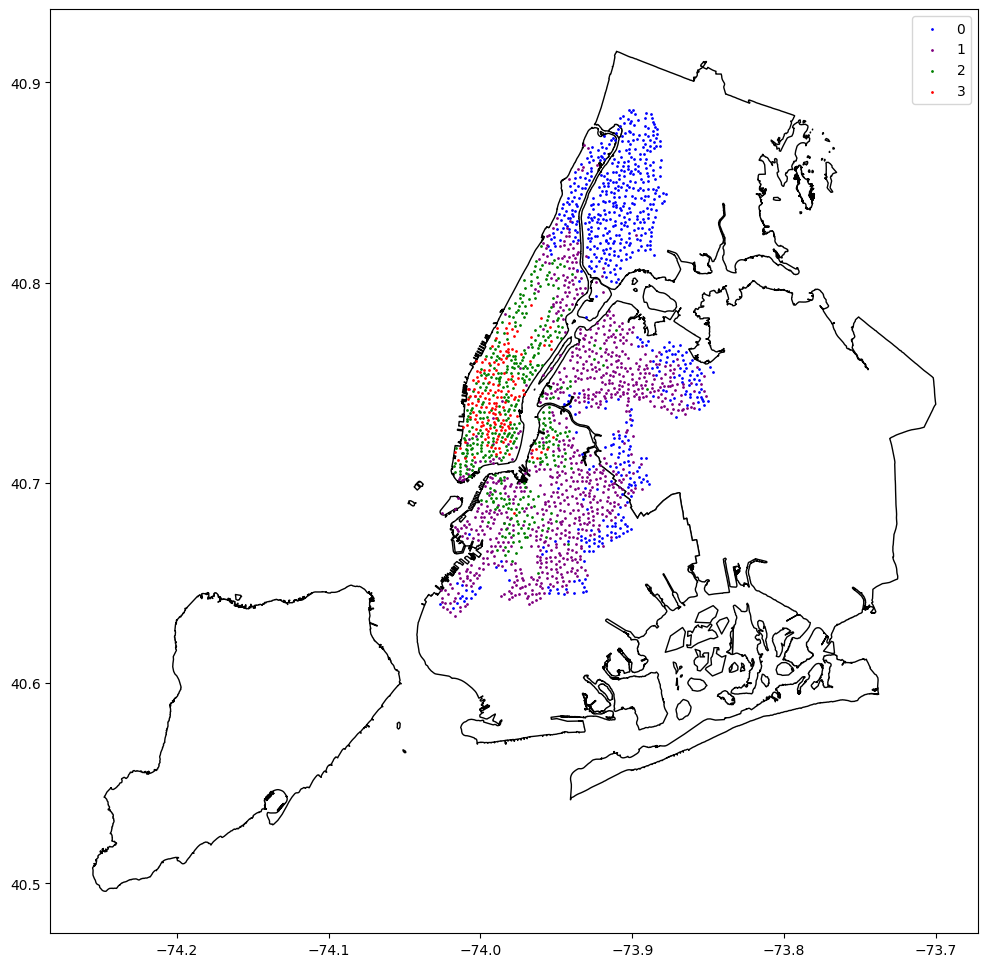

In [44]:
# Plot the data
base = gdf.plot(color='white', edgecolor='black')
colors = {0: 'blue', 1: 'purple', 2: 'green', 3: 'red'}
for group, data in g_stations.groupby('kmeans_label'):
    data.plot(ax=base, marker='o', c=colors[group], markersize=1, label=group)
plt.legend()
plt.show()